In [1]:
import sys, glob, os
import h5py
import numba

sys.path.append(os.path.expanduser("~")+'/uvpy/')
import uvfunctions as uvf
import uvplot as uvp
import uvtests as uvt

sys.path.append(os.path.expanduser("~")+'/CEUAS/CEUAS/public/cds-backend/code/')
import cds_eua4 as eua

import matplotlib
import matplotlib.pylab as plt
import matplotlib.pyplot as maplt
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams['lines.linewidth'] = 3


import numpy as np
import pandas as pd

import ray
ray.init(num_cpus=80)

no config found


2023-07-10 14:28:39,499	INFO worker.py:1528 -- Started a local Ray instance.


Python version:,3.10.6
Ray version:,2.1.0


In [2]:
@numba.jit(nopython=True)
def sel_platform_type(ts, pt, start, end):
    out = np.unique(pt[np.logical_and(ts >= start, ts <= end)])
    if len(out) == 0:
        return 999
    elif len(out) != 1:
        return 100
    else:
        return int(out[0])

@ray.remote    
def find_platform_type(f, start, end):
    with h5py.File(f) as file:
        pt = np.array(file['header_table']['platform_type'][:])
        ts = np.array(file['header_table']['record_timestamp'][:])
        lat = file['header_table']['latitude'][-1]
        lon = file['header_table']['longitude'][-1]
    return [f, sel_platform_type(ts, pt, start, end), float(lat), float(lon)]


In [27]:
def plot_platform_type(year):
    
    sd = year + '-07-01'
    ed = year + '-07-31'
    start = uvf.datetime_to_seconds(np.datetime64(sd))
    end = uvf.datetime_to_seconds(np.datetime64(ed))
    files = glob.glob('/mnt/users/scratch/leo/scratch/converted_v13/long/*.nc')

    result_ids = []
    for i in files[:]:
        result_ids.append(find_platform_type.remote(i, start, end))

    results = ray.get(result_ids)

    rdf = pd.DataFrame.from_dict({'platform_type': list(np.array(results)[:, 1].astype(int)), 'lat': list(np.array(results)[:, 2].astype(float)), 'lon': list(np.array(results)[:, 3].astype(float)), 'name': list(np.array(results)[:, 0])})
    rdf_cleaned = rdf[rdf.platform_type != 999]

    color_continuous_scale=[(0.00, "red"),   (0.50, "red"),
                            (0.50, "blue"),  (1.00, "blue")]
    img = uvp.world_map_plot(data = rdf_cleaned.platform_type, lat_list=rdf_cleaned.lat, lon_list=rdf_cleaned.lon, lable_list=rdf_cleaned.name, title=year + ' platform_type', marker_size = 10, cs=color_continuous_scale, show=False)
    img.write_image('world_map_plot_platform_type_'+sd+'.png')


In [28]:
plot_platform_type(year = '1950')
plot_platform_type(year = '1980')
plot_platform_type(year = '2010')


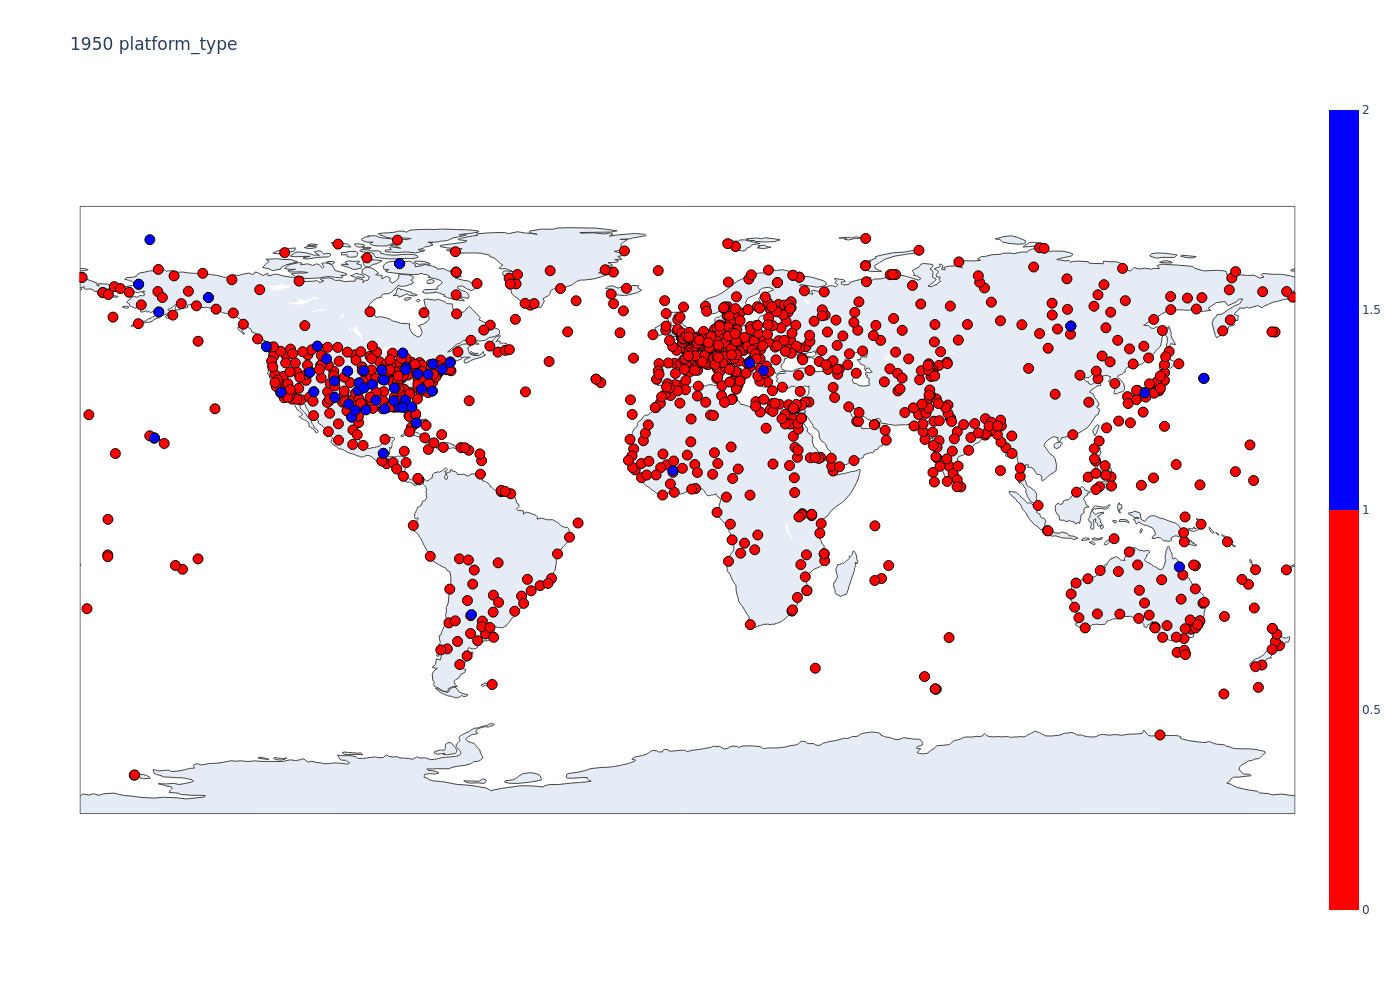

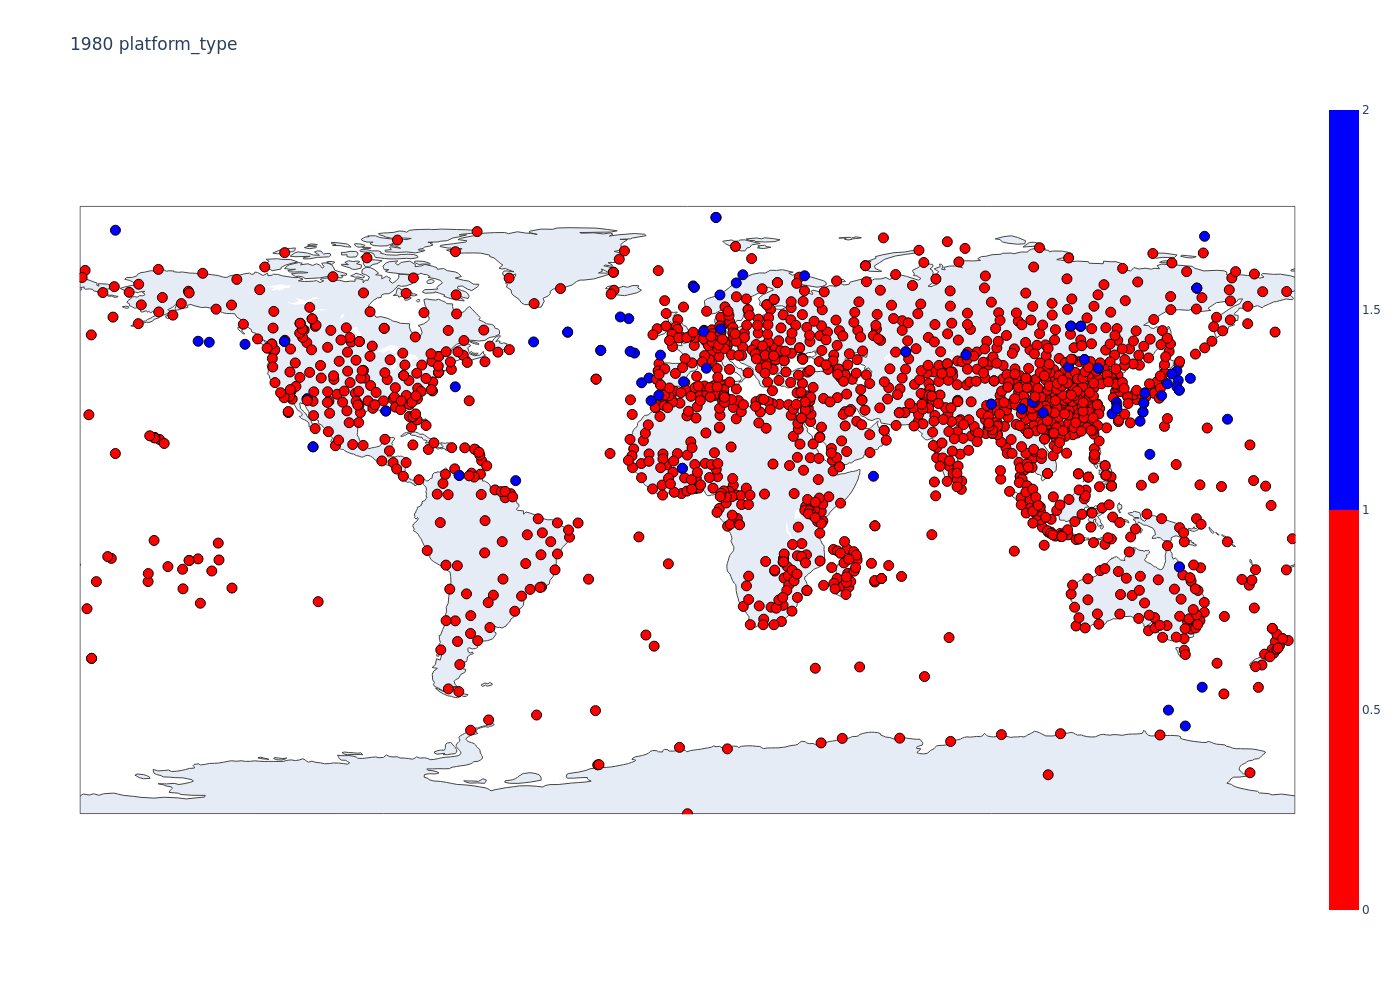

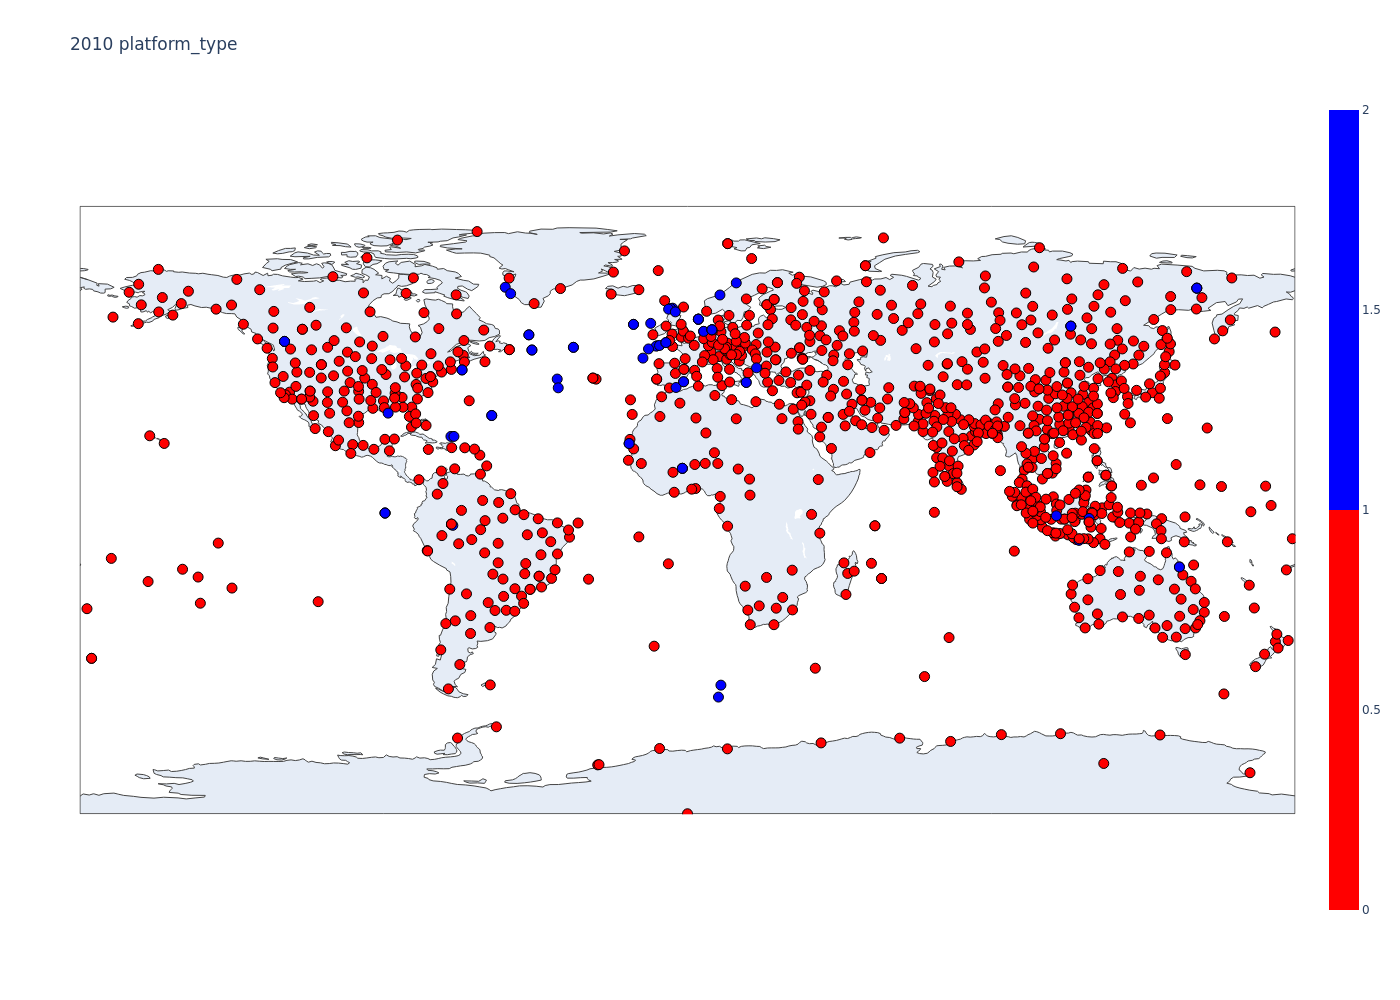

In [29]:
from IPython.display import Image
display(Image(filename='./world_map_plot_platform_type_1950-07-01.png'))
display(Image(filename='./world_map_plot_platform_type_1980-07-01.png'))
display(Image(filename='./world_map_plot_platform_type_2010-07-01.png'))
